# Otto商品分类——LightGBM
原始特征+tfidf特征

我们以Kaggle 2015年举办的Otto Group Product Classification Challenge竞赛数据为例，对LightGBM的超参数进行调优。

Otto数据集是著名电商Otto提供的一个多类商品分类问题，类别数=9. 每个样本有93维数值型特征（整数，表示某种事件发生的次数，已经进行过脱敏处理）。 竞赛官网：https://www.kaggle.com/c/otto-group-product-classification-challenge/data


第一名：https://www.kaggle.com/c/otto-group-product-classification-challenge/discussion/14335
第二名：http://blog.kaggle.com/2015/06/09/otto-product-classification-winners-interview-2nd-place-alexander-guschin/

In [1]:
# 首先 import 必要的模块
import pandas as pd 
import numpy as np

import lightgbm as lgbm
from lightgbm.sklearn import LGBMClassifier

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

## 读取数据

In [2]:
# 读取数据
# 这里使用原始特征+tf_idf特征，log(x+1)特征为原始特的单调变换，加上log特征对决策树模型影响不大
# path to where the data lies
dpath = './data/'

train1 = pd.read_csv(dpath +"Otto_FE_train_org.csv")
train2 = pd.read_csv(dpath +"Otto_FE_train_tfidf.csv")

#去掉多余的id
train2 = train2.drop(["id","target"], axis=1)
train =  pd.concat([train1, train2], axis = 1, ignore_index=False)
train.head()

del train1
del train2

## 准备数据

In [3]:
# 将类别字符串变成数字，LightGBM不支持字符串格式的特征输入/标签输入
y_train = train['target'] #形式为Class_x
y_train = y_train.map(lambda s: s[6:])
y_train = y_train.map(lambda s: int(s) - 1)#将类别的形式由Class_x变为0-8之间的整数

X_train = train.drop(["id", "target"], axis=1)

#保存特征名字以备后用（可视化）
feat_names = X_train.columns 

#sklearn的学习器大多之一稀疏数据输入，模型训练会快很多
#查看一个学习器是否支持稀疏数据，可以看fit函数是否支持: X: {array-like, sparse matrix}.
#可自行用timeit比较稠密数据和稀疏数据的训练时间
from scipy.sparse import csr_matrix
X_train = csr_matrix(X_train)

## LightGBM超参数调优

LightGBM的主要的超参包括：
1. 树的数目n_estimators 和 学习率 learning_rate
2. 树的最大深度max_depth 和 树的最大叶子节点数目num_leaves（注意：XGBoost只有max_depth，LightGBM采用叶子优先的方式生成树，num_leaves很重要，设置成比 2^max_depth 小）
3. 叶子结点的最小样本数:min_data_in_leaf(min_data, min_child_samples)
4. 每棵树的列采样比例：feature_fraction/colsample_bytree
5. 每棵树的行采样比例：bagging_fraction （需同时设置bagging_freq=1）/subsample
6. 正则化参数lambda_l1(reg_alpha), lambda_l2(reg_lambda)

7. 两个非模型复杂度参数，但会影响模型速度和精度。可根据特征取值范围和样本数目修改这两个参数
1）特征的最大bin数目max_bin：默认255；
2）用来建立直方图的样本数目subsample_for_bin：默认200000。

对n_estimators，用LightGBM内嵌的cv函数调优，因为同XGBoost一样，LightGBM学习的过程内嵌了cv，速度极快。
其他参数用GridSearchCV

In [7]:
MAX_ROUNDS = 10000

### 相同的交叉验证分组

In [4]:
# prepare cross validation
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=3)

### 1. n_estimators

In [5]:
#直接调用lightgbm内嵌的交叉验证(cv)，可对连续的n_estimators参数进行快速交叉验证
#而GridSearchCV只能对有限个参数进行交叉验证，且速度相对较慢
def get_n_estimators(params , X_train , y_train , early_stopping_rounds=10):
    lgbm_params = params.copy()
    lgbm_params['num_class'] = 9
     
    lgbmtrain = lgbm.Dataset(X_train , y_train )
     
    #num_boost_round为弱分类器数目，下面的代码参数里因为已经设置了early_stopping_rounds
    #即性能未提升的次数超过过早停止设置的数值，则停止训练
    cv_result = lgbm.cv(lgbm_params , lgbmtrain , num_boost_round=MAX_ROUNDS , nfold=3,  metrics='multi_logloss' , early_stopping_rounds=early_stopping_rounds,seed=3 )
     
    print('best n_estimators:' , len(cv_result['multi_logloss-mean']))
    print('best cv score:' , cv_result['multi_logloss-mean'][-1])
     
    return len(cv_result['multi_logloss-mean'])

In [22]:
params = {'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'n_jobs': 4,
          'learning_rate': 0.1,
          'num_leaves': 60,
          'max_depth': 6,
          'max_bin': 127, #2^6,原始特征为整数，很少超过100
          'subsample': 0.7,
          'bagging_freq': 1,
          'colsample_bytree': 0.7,
         }

n_estimators_1 = get_n_estimators(params , X_train , y_train)

('best n_estimators:', 367)
('best cv score:', 0.47769107806842354)


### 2. num_leaves & max_depth=7
num_leaves建议70-80，搜索区间50-80,值越大模型越复杂，越容易过拟合
相应的扩大max_depth=7

In [26]:
params = {'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'num_class':9, 
          'n_jobs': 4,
          'learning_rate': 0.1,
          'n_estimators':n_estimators_1,
          'max_depth': 7,
          'max_bin': 127, #2^6,原始特征为整数，很少超过100
          'subsample': 0.7,
          'bagging_freq': 1,
          'colsample_bytree': 0.7,
         }
lg = LGBMClassifier(silent=False,  **params)

num_leaves_s = range(50,90,10) #50,60,70,80
tuned_parameters = dict( num_leaves = num_leaves_s)

grid_search = GridSearchCV(lg, n_jobs=4, param_grid=tuned_parameters, cv = kfold, scoring="neg_log_loss", verbose=5, refit = False)
grid_search.fit(X_train , y_train)
#grid_search.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] num_leaves=50 ...................................................
[CV] num_leaves=50 ...................................................
[CV] num_leaves=50 ...................................................
[CV] num_leaves=60 ...................................................
[CV] ............. num_leaves=50, score=-0.477027063428, total= 2.8min
[CV] num_leaves=60 ...................................................
[CV] ............. num_leaves=50, score=-0.464917364591, total= 2.8min
[CV] num_leaves=60 ...................................................
[CV] ............. num_leaves=50, score=-0.474821886821, total= 2.9min
[CV] num_leaves=70 ...................................................
[CV] ............. num_leaves=60, score=-0.465821352444, total= 2.9min
[CV] num_leaves=70 ...................................................
[CV] ............. num_leaves=60, score=-0.479422725074, total= 2.7min
[CV] num_leaves=7

[Parallel(n_jobs=4)]: Done   8 out of  12 | elapsed:  6.8min remaining:  3.4min


[CV] ............. num_leaves=70, score=-0.478245606292, total= 2.6min
[CV] ............. num_leaves=80, score=-0.473039369028, total= 2.8min
[CV] ............. num_leaves=80, score=-0.478740844173, total= 2.8min
[CV] .............. num_leaves=80, score=-0.46523376084, total= 2.8min


[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 10.0min finished


AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [27]:
# examine the best model
print(-grid_search.best_score_)
print(grid_search.best_params_)

0.472182225226
{'num_leaves': 70}


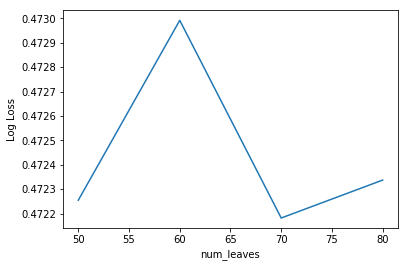

In [28]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
train_means = grid_search.cv_results_[ 'mean_train_score' ]
train_stds = grid_search.cv_results_[ 'std_train_score' ]

n_leafs = len(num_leaves_s)

x_axis = num_leaves_s
plt.plot(x_axis, -test_means)
#plt.errorbar(x_axis, -test_means, yerr=test_stds,label = ' Test')
#plt.errorbar(x_axis, -train_means, yerr=train_stds,label = ' Train')
plt.xlabel( 'num_leaves' )
plt.ylabel( 'Log Loss' )
plt.show()

In [29]:
test_means

array([-0.47225505, -0.47299178, -0.47218223, -0.47233755])

#### 性能抖动，取系统推荐值：70, 不必再细调

### 3. min_child_samples
叶子节点的最小样本数目

叶子节点数目：70，共9类，平均每类8个叶子节点
每棵树的样本数目数目最少的类（稀有事件）的样本数目：200 * 2/3 * 0.7 = 100
所以每个叶子节点约100/8 = 12个样本点

搜索范围：10-50

In [32]:
params = {'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'num_class':9, 
          'n_jobs': 4,
          'learning_rate': 0.1,
          'n_estimators':n_estimators_1,
          'max_depth': 7,
          'num_leaves':70,
          'max_bin': 127, #2^6,原始特征为整数，很少超过100
          'subsample': 0.7,
          'bagging_freq': 1,
          'colsample_bytree': 0.7,
         }
lg = LGBMClassifier(silent=False,  **params)

min_child_samples_s = range(10,50,10) 
tuned_parameters = dict( min_child_samples = min_child_samples_s)

grid_search = GridSearchCV(lg, n_jobs=4,  param_grid=tuned_parameters, cv = kfold, scoring="neg_log_loss", verbose=5, refit = False)
grid_search.fit(X_train , y_train)
grid_search.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] min_child_samples=10 ............................................
[CV] min_child_samples=10 ............................................
[CV] min_child_samples=10 ............................................
[CV] min_child_samples=20 ............................................
[CV] ...... min_child_samples=20, score=-0.466571788165, total= 2.5min
[CV] min_child_samples=20 ............................................
[CV] ...... min_child_samples=10, score=-0.478245606292, total= 2.7min
[CV] min_child_samples=20 ............................................
[CV] ...... min_child_samples=10, score=-0.463754927719, total= 2.7min
[CV] min_child_samples=30 ............................................
[CV] ...... min_child_samples=10, score=-0.474547546755, total= 2.7min
[CV] min_child_samples=30 ............................................
[CV] ...... min_child_samples=20, score=-0.474307767566, total= 2.7min
[CV] min_child_sa

[Parallel(n_jobs=4)]: Done   8 out of  12 | elapsed:  6.3min remaining:  3.1min


[CV] ...... min_child_samples=30, score=-0.478580196188, total= 2.6min
[CV] ...... min_child_samples=40, score=-0.479780000235, total= 2.7min
[CV] ...... min_child_samples=40, score=-0.476378969622, total= 2.7min
[CV] ...... min_child_samples=40, score=-0.466245168613, total= 2.7min


[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:  9.4min finished


AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [33]:
# examine the best model
print(-grid_search.best_score_)
print(grid_search.best_params_)

0.472078455459
{'min_child_samples': 30}


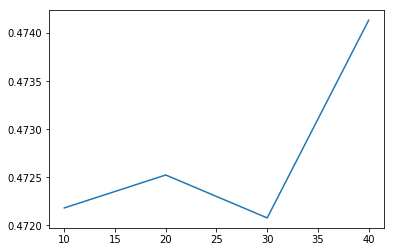

In [34]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
train_means = grid_search.cv_results_[ 'mean_train_score' ]
train_stds = grid_search.cv_results_[ 'std_train_score' ]

x_axis = min_child_samples_s

plt.plot(x_axis, -test_means)
#plt.errorbar(x_axis, -test_scores, yerr=test_stds ,label = ' Test')
#plt.errorbar(x_axis, -train_scores, yerr=train_stds,label =  +' Train')

plt.show()

In [35]:
test_means

array([-0.47218223, -0.4725249 , -0.47207846, -0.47413428])

#### min_child_samples=30

### 行采样参数 sub_samples/bagging_fraction

In [43]:
params = {'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'num_class':9, 
          'n_jobs': 4,
          'learning_rate': 0.1,
          'n_estimators':n_estimators_1,
          'max_depth': 7,
          'num_leaves':70,
          'min_child_samples':30,
          'max_bin': 127, #2^6,原始特征为整数，很少超过100
          #'subsample': 0.7,
          'bagging_freq': 1,
          'colsample_bytree': 0.7,
         }
lg = LGBMClassifier(silent=False,  **params)

subsample_s = [i/10.0 for i in range(5,10)]
tuned_parameters = dict( subsample = subsample_s)

grid_search = GridSearchCV(lg, n_jobs=4,  param_grid=tuned_parameters, cv = kfold, scoring="neg_log_loss", verbose=5, refit = False)
grid_search.fit(X_train , y_train)
#grid_search.best_estimator_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] subsample=0.5 ...................................................
[CV] subsample=0.5 ...................................................
[CV] subsample=0.5 ...................................................
[CV] subsample=0.6 ...................................................
[CV] ............. subsample=0.5, score=-0.469257981732, total= 2.5min
[CV] subsample=0.6 ...................................................
[CV] .............. subsample=0.5, score=-0.47697491531, total= 2.5min
[CV] subsample=0.6 ...................................................
[CV] ............. subsample=0.5, score=-0.479783198794, total= 2.5min
[CV] subsample=0.7 ...................................................
[CV] .............. subsample=0.6, score=-0.46619254611, total= 2.7min
[CV] subsample=0.7 ...................................................
[CV] .............. subsample=0.6, score=-0.48041065537, total= 2.4min
[CV] subsample=0.

[Parallel(n_jobs=4)]: Done  12 out of  15 | elapsed:  9.0min remaining:  2.3min


[CV] .............. subsample=0.9, score=-0.46590046365, total= 1.9min
[CV] ............. subsample=0.9, score=-0.474834041484, total= 1.8min
[CV] ............. subsample=0.9, score=-0.479633659338, total= 1.6min


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed: 10.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=3, shuffle=True),
       error_score='raise',
       estimator=LGBMClassifier(bagging_freq=1, boosting_type='gbdt', colsample_bytree=0.7,
        learning_rate=0.1, max_bin=127, max_depth=7, min_child_samples=30,
        min_child_weight=5, min_split_gain=0.0, n_estimators=367, n_jobs=4,
        num_class=9, num_leaves=70, objective='multiclass', random_state=0,
        reg_alpha=0.0, reg_lambda=0.0, silent=False, subsample=1.0,
        subsample_for_bin=50000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'subsample': [0.5, 0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='neg_log_loss', verbose=5)

In [44]:
# examine the best model
print(-grid_search.best_score_)
print(grid_search.best_params_)

0.472015607056
{'subsample': 0.8}


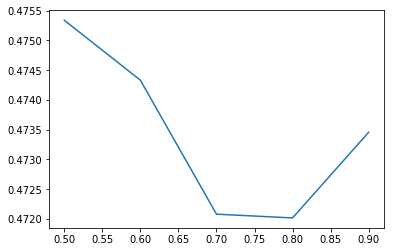

In [45]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
train_means = grid_search.cv_results_[ 'mean_train_score' ]
train_stds = grid_search.cv_results_[ 'std_train_score' ]

x_axis = subsample_s

plt.plot(x_axis, -test_means)
#plt.errorbar(x_axis, -test_scores[:,i], yerr=test_stds[:,i] ,label = str(max_depths[i]) +' Test')
#plt.errorbar(x_axis, -train_scores[:,i], yerr=train_stds[:,i] ,label = str(max_depths[i]) +' Train')

plt.show()

In [47]:
test_means

array([-0.47533836, -0.47433055, -0.47207846, -0.47201561, -0.47345561])

#### subsample=0.8

### 列采样参数 sub_feature/feature_fraction/colsample_bytree

In [48]:
params = {'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'num_class':9, 
          'n_jobs': 4,
          'learning_rate': 0.1,
          'n_estimators':n_estimators_1,
          'max_depth': 7,
          'num_leaves':70,
          'min_child_samples':30,
          'max_bin': 127, #2^6,原始特征为整数，很少超过100
          'subsample': 0.8,
          'bagging_freq': 1,
          #'colsample_bytree': 0.7,
         }
lg = LGBMClassifier(silent=False,  **params)

colsample_bytree_s = [i/10.0 for i in range(5,10)]
tuned_parameters = dict( colsample_bytree = colsample_bytree_s)

grid_search = GridSearchCV(lg, n_jobs=4,  param_grid=tuned_parameters, cv = kfold, scoring="neg_log_loss", verbose=5, refit = False)
grid_search.fit(X_train , y_train)
#grid_search.best_estimator_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] colsample_bytree=0.5 ............................................
[CV] colsample_bytree=0.5 ............................................
[CV] colsample_bytree=0.5 ............................................
[CV] colsample_bytree=0.6 ............................................
[CV] ...... colsample_bytree=0.5, score=-0.476915446285, total= 2.5min
[CV] colsample_bytree=0.6 ............................................
[CV] ...... colsample_bytree=0.5, score=-0.466218783943, total= 2.5min
[CV] colsample_bytree=0.6 ............................................
[CV] ...... colsample_bytree=0.6, score=-0.464009186923, total= 2.5min
[CV] colsample_bytree=0.7 ............................................
[CV] ...... colsample_bytree=0.5, score=-0.472521234575, total= 2.6min
[CV] colsample_bytree=0.7 ............................................
[CV] ....... colsample_bytree=0.6, score=-0.47807013336, total= 8.6min
[CV] colsample_by

[Parallel(n_jobs=4)]: Done  12 out of  15 | elapsed: 15.7min remaining:  3.9min


[CV] ...... colsample_bytree=0.9, score=-0.466656187743, total= 1.8min
[CV] ...... colsample_bytree=0.9, score=-0.481547524759, total= 1.7min
[CV] ...... colsample_bytree=0.9, score=-0.475279420194, total= 1.8min


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed: 17.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=3, shuffle=True),
       error_score='raise',
       estimator=LGBMClassifier(bagging_freq=1, boosting_type='gbdt', colsample_bytree=1.0,
        learning_rate=0.1, max_bin=127, max_depth=7, min_child_samples=30,
        min_child_weight=5, min_split_gain=0.0, n_estimators=367, n_jobs=4,
        num_class=9, num_leaves=70, objective='multiclass', random_state=0,
        reg_alpha=0.0, reg_lambda=0.0, silent=False, subsample=0.8,
        subsample_for_bin=50000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='neg_log_loss', verbose=5)

In [49]:
# examine the best model
print(-grid_search.best_score_)
print(grid_search.best_params_)

0.4718848092
{'colsample_bytree': 0.5}


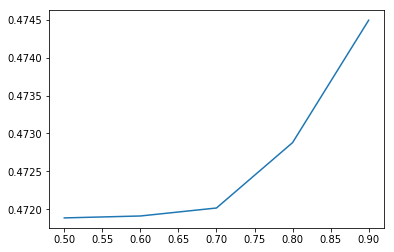

In [50]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
train_means = grid_search.cv_results_[ 'mean_train_score' ]
train_stds = grid_search.cv_results_[ 'std_train_score' ]

x_axis = colsample_bytree_s

plt.plot(x_axis, -test_means)
#plt.errorbar(x_axis, -test_scores[:,i], yerr=test_stds[:,i] ,label = str(max_depths[i]) +' Test')
#plt.errorbar(x_axis, -train_scores[:,i], yerr=train_stds[:,i] ,label = str(max_depths[i]) +' Train')

plt.show()

再调小一点，由于特征包括原始特征+tfidf特征，是多了些

In [52]:
params = {'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'num_class':9, 
          'n_jobs': 4,
          'learning_rate': 0.1,
          'n_estimators':n_estimators_1,
          'max_depth': 7,
          'num_leaves':70,
          'min_child_samples':30,
          'max_bin': 127, #2^6,原始特征为整数，很少超过100
          'subsample': 0.8,
          'bagging_freq': 1,
          #'colsample_bytree': 0.7,
         }
lg = LGBMClassifier(silent=False,  **params)

colsample_bytree_s = [i/10.0 for i in range(3,5)]
tuned_parameters = dict( colsample_bytree = colsample_bytree_s)

grid_search = GridSearchCV(lg, n_jobs=4,  param_grid=tuned_parameters, cv = kfold, scoring="neg_log_loss", verbose=5, refit = False)
grid_search.fit(X_train , y_train)
#grid_search.best_estimator_

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] colsample_bytree=0.3 ............................................
[CV] colsample_bytree=0.3 ............................................
[CV] colsample_bytree=0.3 ............................................
[CV] colsample_bytree=0.4 ............................................
[CV] ...... colsample_bytree=0.4, score=-0.464755694588, total= 2.6min
[CV] colsample_bytree=0.4 ............................................
[CV] ....... colsample_bytree=0.3, score=-0.48017892987, total= 2.8min
[CV] colsample_bytree=0.4 ............................................
[CV] ...... colsample_bytree=0.3, score=-0.467187209499, total= 2.8min


[Parallel(n_jobs=4)]: Done   3 out of   6 | elapsed:  3.3min remaining:  3.3min


[CV] ...... colsample_bytree=0.3, score=-0.473636056634, total= 2.9min
[CV] ...... colsample_bytree=0.4, score=-0.477367326177, total=  53.0s
[CV] ...... colsample_bytree=0.4, score=-0.471301958071, total=  58.2s


[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:  4.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=3, shuffle=True),
       error_score='raise',
       estimator=LGBMClassifier(bagging_freq=1, boosting_type='gbdt', colsample_bytree=1.0,
        learning_rate=0.1, max_bin=127, max_depth=7, min_child_samples=30,
        min_child_weight=5, min_split_gain=0.0, n_estimators=367, n_jobs=4,
        num_class=9, num_leaves=70, objective='multiclass', random_state=0,
        reg_alpha=0.0, reg_lambda=0.0, silent=False, subsample=0.8,
        subsample_for_bin=50000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'colsample_bytree': [0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='neg_log_loss', verbose=5)

In [53]:
# examine the best model
print(-grid_search.best_score_)
print(grid_search.best_params_)

0.471141251983
{'colsample_bytree': 0.4}


#### colsample_bytree=0.4

### 正则化参数lambda_l1(reg_alpha), lambda_l2(reg_lambda)感觉不用调了

### 减小学习率，调整n_estimators

In [56]:
params = {'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'num_class':9, 
          'n_jobs': 4,
          'learning_rate': 0.01,
          #'n_estimators':n_estimators_1,
          'max_depth': 7,
          'num_leaves':70,
          'min_child_samples':30,
          'max_bin': 127, #2^6,原始特征为整数，很少超过100
          'subsample': 0.8,
          'bagging_freq': 1,
          'colsample_bytree': 0.4,
         }
n_estimators_2 = get_n_estimators(params , X_train , y_train)

('best n_estimators:', 3813)
('best cv score:', 0.46598789257637724)


### 用所有训练数据，采用最佳参数重新训练模型
由于样本数目增多，模型复杂度稍微扩大一点？
num_leaves增多5
min_child_samples按样本比例增加到40

In [57]:
params = {'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'num_class':9, 
          'n_jobs': 4,
          'learning_rate': 0.01,
          'n_estimators':n_estimators_2,
          'max_depth': 7,
          'num_leaves':75,
          'min_child_samples':40,
          'max_bin': 127, #2^6,原始特征为整数，很少超过100
          'subsample': 0.8,
          'bagging_freq': 1,
          'colsample_bytree': 0.4,
         }

lg = LGBMClassifier(silent=False,  **params)
lg.fit(X_train, y_train)

LGBMClassifier(bagging_freq=1, boosting_type='gbdt', colsample_bytree=0.4,
        learning_rate=0.01, max_bin=127, max_depth=7, min_child_samples=40,
        min_child_weight=5, min_split_gain=0.0, n_estimators=3813,
        n_jobs=4, num_class=9, num_leaves=75, objective='multiclass',
        random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=False,
        subsample=0.8, subsample_for_bin=50000, subsample_freq=1)

## 保存模型，用于后续测试

In [58]:
import cPickle

cPickle.dump(lg, open("Otto_LightGBM_org_tfidf.pkl", 'wb'))

### 特征重要性

In [59]:
df = pd.DataFrame({"columns":list(feat_names), "importance":list(lg.feature_importances_.T)})
df = df.sort_values(by=['importance'],ascending=False)

In [60]:
df

,columns,importance
117,feat_25_tfidf,30088
159,feat_67_tfidf,29145
140,feat_48_tfidf,27100
116,feat_24_tfidf,26741
132,feat_40_tfidf,25868
178,feat_86_tfidf,24690
106,feat_14_tfidf,21896
154,feat_62_tfidf,18416
108,feat_16_tfidf,16358
107,feat_15_tfidf,16313


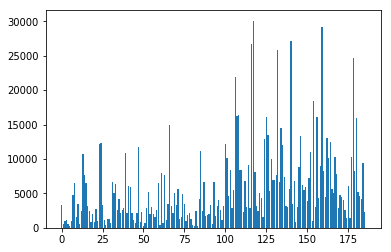

In [61]:
plt.bar(range(len(lg.feature_importances_)), lg.feature_importances_)
plt.show()

tfidf的特征重要性更高一些。